<h1>Caso de Análisis de Datos</h1>
<h3>Conjunto de datos: Car Insurance Claim Prediction</h3>
<h3>Autora Conjunto de Datos: Iftesha Najnin</h3>

In [1]:
import pandas as pd 
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn import over_sampling
#from imblearn.over_sampling import RandomOverSampler



<h1>Parte 1: Predicción sin uso de Técnicas de Big Data</h1>
<h2>Ingesta de datos</h2>


In [2]:
df = pd.read_csv('claim_prediction_train.csv', delimiter=',', encoding='latin-1')
print(df.head(10))

  policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster  \
0   ID00001       0.515874        0.05             0.644231           C1   
1   ID00002       0.672619        0.02             0.375000           C2   
2   ID00003       0.841110        0.02             0.384615           C3   
3   ID00004       0.900277        0.11             0.432692           C4   
4   ID00005       0.596403        0.11             0.634615           C5   
5   ID00006       1.018709        0.07             0.519231           C6   
6   ID00007       0.097992        0.16             0.403846           C7   
7   ID00008       0.509085        0.14             0.423077           C8   
8   ID00009       0.282394        0.07             0.298077           C7   
9   ID00010       0.566255        0.04             0.442308           C9   

   population_density  make segment model fuel_type  ... is_brake_assist  \
0                4990     1       A    M1       CNG  ...              No   
1          

<h3>Limpieza Preliminar</h3>

In [3]:
# Eliminamos los valores ID
df = df.drop(['policy_id'], axis=1)
#Sustituimos los valores binarios por 1 y 0
df = df.replace('Yes',1)
df = df.replace('No',0)
# Quitamos la C de area cluster y la M en modelo
df['area_cluster'] = df['area_cluster'].str.replace('C', '')
df['model'] = df['model'].str.replace('M', '')

#Tratamos todas las columnas no numericas
le = LabelEncoder()
cat_col =['segment', 'fuel_type','max_torque','max_power','engine_type','rear_brakes_type','transmission_type', 'steering_type']
for cat in cat_col:
    df[cat] = le.fit_transform(df[cat])


<h2>Entrenamiento Datos Inicial</h2>

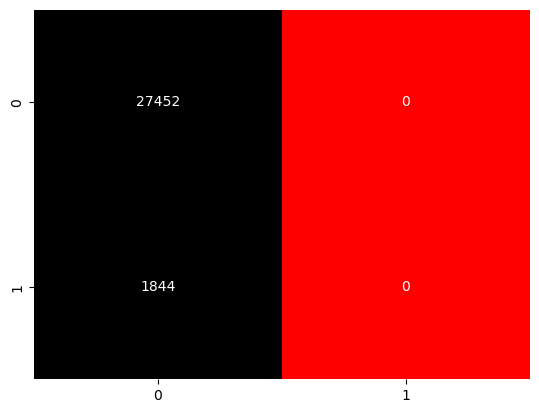

In [4]:
# Seleccionamos la variable dependiente y preparamos el conjunto de datos de prueba
X= df.drop("is_claim", axis=1)
# Resto de columnas para preveer la variable dependiente
y=df["is_claim"]
# Variables que generaremos para el entrenamiento
X_entrena, X_prueba, y_entrena, y_prueba = train_test_split(X,y,train_size=0.5)
# Configuramos el modelo de entrenamiento y lo entrenamos con los datos generados
logistic_model = LogisticRegression()
logistic_model.fit(X_entrena, y_entrena)
#Evaluamos el modelo
y_validacion_pred = logistic_model.predict(X_prueba)
conf_matrix = confusion_matrix(y_prueba, y_validacion_pred)
ax = sns.heatmap(
    conf_matrix, # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)   


<h3>Resultado Entrenamiento Datos</h3>

In [5]:
print("\nPrecisión: {:.4f}".format(accuracy_score(y_prueba, y_validacion_pred)))
print("\nRecall: {:.4f}".format(recall_score(y_prueba, y_validacion_pred)))
print("\nF1: {:.4f}".format(f1_score(y_prueba, y_validacion_pred)))


Precisión: 0.9371

Recall: 0.0000

F1: 0.0000


<h4>Conclusión</h4>
<p>A pesar de que la precisión del modelo es excepcionalmente buena, ya que su <b>precisión</b> está por encima del 80%</p>
<p>Podemos ver que las funciones Recall y F1 tiene valor de 0, lo que nos señala que existe un gran sesgo de clasificación</p>
<p>En la matriz de confusión podemos ver que clasifica todo resultado como 0, haciendo que en definidas cuentas no clasifique</p>

<h1>Parte 2: Predicción usando Big Data</h1>
<h2>Análisis de Datos</h2>

Variables nulas:  policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length                          

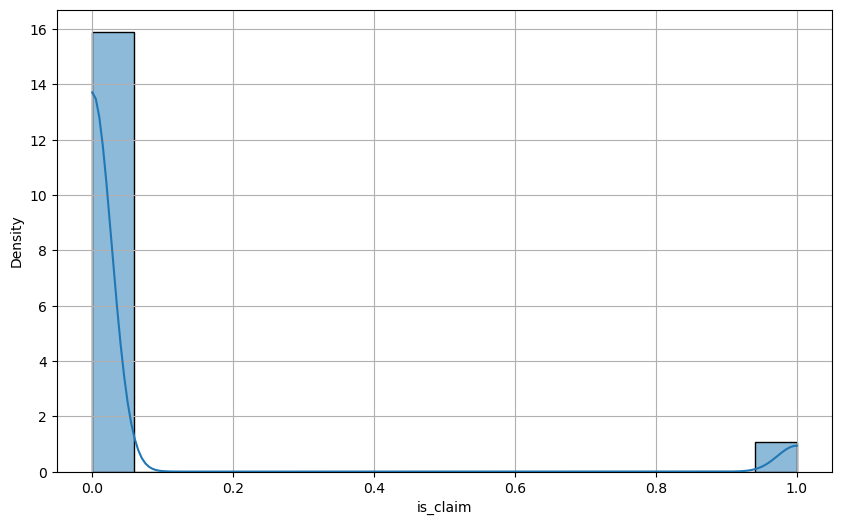

In [6]:
# Analizamos el numero de variables nulas
print("Variables nulas: ", df.isnull().sum())
# Analizamos el número de variables duplicadas
print("Variables duplicadas: ", df.duplicated().sum())
# Analizamos la variable objetivo
print(df['is_claim'].describe())
print("Resultados variable objetivo:",df['is_claim'].value_counts())
  
plt.figure(figsize=(10, 6))
sns.histplot(df['is_claim'], kde=True, stat="density")
plt.xlabel('is_claim')
plt.ylabel('Density')
plt.grid(True)
plt.show()


<h4>Conclusión</h4>
<p>Se puede ver un fuerte desequilibrio en los datos, viendo que tiene una gran diferencia entre casos que no presentaran ninguna reclamación de los que sí</p>

In [7]:
# Asimetría
print("Skewness: %f" % df['is_claim'].skew())
# Curtosis
print("Kurtosis: %f" % df['is_claim'].kurt())

Skewness: 3.563967
Kurtosis: 10.702226


<h4>Conclusión</h4>
<p>Por su Asímetria confirmamos la hipotesis de que existe un gran desequilibrio entre los valores objetivos positivos y negativos, a favor de los negativos</p>
<p>Por su Curtosis nos damos cuenta de que la diferencia entre los valores es muy elevada</p>

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15580\1449899112.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


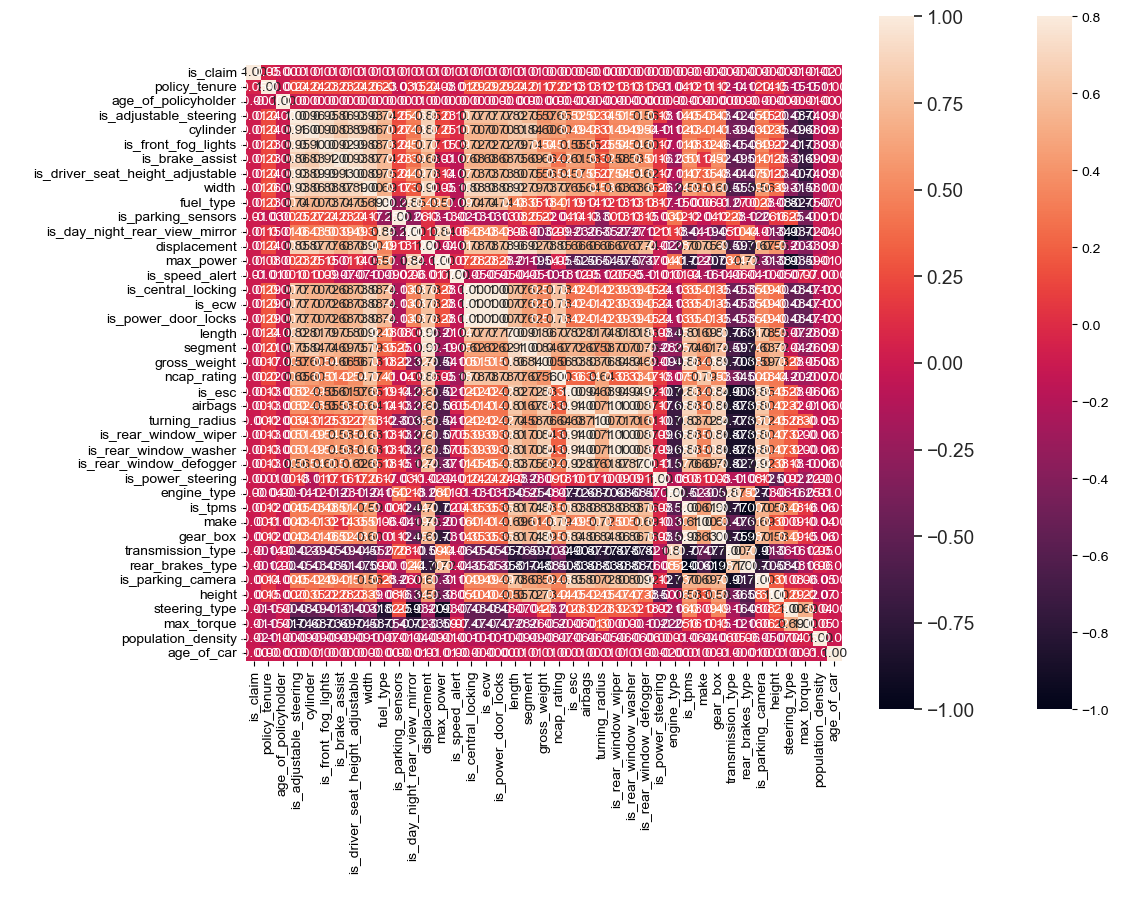

In [8]:
# Matriz de correlación
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
k = 100 # Número de variables.
cols = corrmat.nlargest(k, 'is_claim')['is_claim'].index
cm = np.corrcoef(df[cols].values.T.astype(int))
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = cols.values, xticklabels = cols.values)
plt.show()

<h4>Conclusión</h4>
<p>Se puede observar una gran correlacion de las variables <b>transmission_type</b>y <b>rear_brakes_type</b> con el resto de variables, lo que nos indica que pueden ser prescindibles</p>

<h2>Limpieza de Datos</h2>

In [9]:
# Eliminación de Datos redundantes
df = df.drop(['transmission_type'], axis=1)
df = df.drop(['rear_brakes_type'], axis=1)

<h3>Normalización de Datos</h3>

In [10]:
escala = MinMaxScaler(feature_range=(0,1))
normado = escala.fit_transform(df)
df = pd.DataFrame(data=normado, columns=df.columns)

<h3>Optimización del Modelo<h3>

In [11]:
# Seleccionamos la variable dependiente y preparamos el conjunto de datos de prueba
X= df.drop("is_claim", axis=1)
# Resto de columnas para preveer la variable dependiente
y=df["is_claim"]
ros = over_sampling.RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
# Set class weights
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10
# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())
param_grid = [
    {'penalty' : ['l1', 'l2', 'elasticnet', ],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
     'max_iter' : [1000,2500, 5000]
    }
]
grid = GridSearchCV(xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc",scale_pos_weight = pos_weight, class_weight=class_weights), param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1, scoring='roc_auc')
best_clf = grid.fit(X_resampled,y_resampled)
print("Mejores estimadores: ",best_clf.best_estimator_)
print("Mejores resultados: ",best_clf.best_score_)
print("Mejores parametros: ",best_clf.best_params_)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "C", "class_weight", "max_iter", "penalty", "solver" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores estimadores:  XGBClassifier(C=0.0001, base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_iter=1000,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)
Mejores resultados:  0.8537611907400567
Mejores parametros:  {'C': 0.0001, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'lbfgs'}


In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK

# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', np.arange(1, 14, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1)
}

# Define the objective function to minimize
def objective(params):
    X= df.drop("is_claim", axis=1)
    y=df["is_claim"]
    ros = over_sampling.RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    X_entrena, X_prueba, y_entrena, y_prueba = train_test_split(X_resampled,y_resampled,train_size=0.5)
    # Set class weights
    class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10
    # Set "scale_pos_weight" based on class balance
    pos_weight = sum(class_weights.values()) / sum(class_weights.keys())
    xgb_model = xgb.XGBClassifier(**params, scale_pos_weight = pos_weight, class_weight=class_weights,objective="binary:logistic", eval_metric="auc")
    xgb_model.fit(X_entrena, y_entrena)
    y_pred = xgb_model.predict(X_prueba)
    score = accuracy_score(y_prueba, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Perform the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



  2%|▉                                              | 2/100 [00:00<00:41,  2.36trial/s, best loss: -0.6292939975202392]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



  4%|█▉                                             | 4/100 [00:01<00:46,  2.05trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



  6%|██▊                                            | 6/100 [00:02<00:42,  2.24trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



  7%|███▎                                           | 7/100 [00:03<00:37,  2.51trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



  8%|███▊                                           | 8/100 [00:04<00:53,  1.73trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



  9%|████▏                                          | 9/100 [00:04<00:48,  1.88trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|████▌                                         | 10/100 [00:05<00:50,  1.80trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█████▌                                        | 12/100 [00:06<00:43,  2.03trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 13%|█████▉                                        | 13/100 [00:06<00:41,  2.10trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|██████▉                                       | 15/100 [00:07<00:37,  2.26trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 17%|███████▊                                      | 17/100 [00:08<00:37,  2.23trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 18%|████████▎                                     | 18/100 [00:08<00:34,  2.36trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 19%|████████▋                                     | 19/100 [00:08<00:31,  2.57trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|█████████▏                                    | 20/100 [00:09<00:29,  2.72trial/s, best loss: -0.6692436729633141]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 21%|█████████▋                                    | 21/100 [00:10<00:37,  2.08trial/s, best loss: -0.8312850995551018]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 22%|██████████                                    | 22/100 [00:10<00:45,  1.70trial/s, best loss: -0.8312850995551018]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 23%|██████████▌                                   | 23/100 [00:11<00:50,  1.51trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 24%|███████████                                   | 24/100 [00:12<00:53,  1.42trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|███████████▌                                  | 25/100 [00:13<00:57,  1.30trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 26%|███████████▉                                  | 26/100 [00:13<00:51,  1.43trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 27%|████████████▍                                 | 27/100 [00:14<00:53,  1.37trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 28%|████████████▉                                 | 28/100 [00:15<00:52,  1.36trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 29%|█████████████▎                                | 29/100 [00:15<00:46,  1.54trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|█████████████▊                                | 30/100 [00:16<00:45,  1.52trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 31%|██████████████▎                               | 31/100 [00:17<00:41,  1.66trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 32%|██████████████▋                               | 32/100 [00:17<00:43,  1.58trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 33%|███████████████▏                              | 33/100 [00:18<00:39,  1.69trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 34%|███████████████▋                              | 34/100 [00:18<00:39,  1.66trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 36%|████████████████▌                             | 36/100 [00:20<00:37,  1.69trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|█████████████████▍                            | 38/100 [00:21<00:36,  1.68trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 39%|█████████████████▉                            | 39/100 [00:22<00:41,  1.46trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|██████████████████▍                           | 40/100 [00:22<00:37,  1.60trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 41%|██████████████████▊                           | 41/100 [00:23<00:37,  1.57trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 42%|███████████████████▎                          | 42/100 [00:23<00:34,  1.68trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:03:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 43%|███████████████████▊                          | 43/100 [00:24<00:38,  1.47trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 44%|████████████████████▏                         | 44/100 [00:25<00:36,  1.55trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 46%|█████████████████████▏                        | 46/100 [00:26<00:32,  1.65trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 47%|█████████████████████▌                        | 47/100 [00:27<00:29,  1.78trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 48%|██████████████████████                        | 48/100 [00:27<00:28,  1.85trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 49%|██████████████████████▌                       | 49/100 [00:27<00:25,  2.00trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|███████████████████████                       | 50/100 [00:28<00:23,  2.09trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 51%|███████████████████████▍                      | 51/100 [00:29<00:28,  1.70trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 52%|███████████████████████▉                      | 52/100 [00:30<00:31,  1.53trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 54%|████████████████████████▊                     | 54/100 [00:30<00:24,  1.87trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████████████████████████▎                    | 55/100 [00:31<00:25,  1.76trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 56%|█████████████████████████▊                    | 56/100 [00:32<00:25,  1.75trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 57%|██████████████████████████▏                   | 57/100 [00:32<00:27,  1.56trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 58%|██████████████████████████▋                   | 58/100 [00:34<00:33,  1.27trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 59%|███████████████████████████▏                  | 59/100 [00:34<00:28,  1.43trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 61%|████████████████████████████                  | 61/100 [00:35<00:24,  1.57trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 62%|████████████████████████████▌                 | 62/100 [00:36<00:22,  1.68trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 63%|████████████████████████████▉                 | 63/100 [00:36<00:19,  1.86trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 64%|█████████████████████████████▍                | 64/100 [00:37<00:20,  1.75trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|█████████████████████████████▉                | 65/100 [00:37<00:18,  1.89trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 66%|██████████████████████████████▎               | 66/100 [00:38<00:19,  1.72trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 67%|██████████████████████████████▊               | 67/100 [00:39<00:21,  1.57trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 68%|███████████████████████████████▎              | 68/100 [00:40<00:21,  1.50trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 69%|███████████████████████████████▋              | 69/100 [00:40<00:21,  1.45trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 71%|████████████████████████████████▋             | 71/100 [00:41<00:17,  1.64trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 72%|█████████████████████████████████             | 72/100 [00:42<00:14,  1.87trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 73%|█████████████████████████████████▌            | 73/100 [00:42<00:14,  1.91trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 74%|██████████████████████████████████            | 74/100 [00:43<00:17,  1.52trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|██████████████████████████████████▌           | 75/100 [00:44<00:16,  1.50trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 76%|██████████████████████████████████▉           | 76/100 [00:45<00:18,  1.31trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 77%|███████████████████████████████████▍          | 77/100 [00:46<00:16,  1.38trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 78%|███████████████████████████████████▉          | 78/100 [00:46<00:14,  1.52trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 79%|████████████████████████████████████▎         | 79/100 [00:46<00:12,  1.71trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████████████████████████████████▊         | 80/100 [00:48<00:14,  1.38trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 81%|█████████████████████████████████████▎        | 81/100 [00:48<00:14,  1.30trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 83%|██████████████████████████████████████▏       | 83/100 [00:49<00:09,  1.74trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|███████████████████████████████████████       | 85/100 [00:50<00:08,  1.86trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 86%|███████████████████████████████████████▌      | 86/100 [00:51<00:08,  1.61trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 88%|████████████████████████████████████████▍     | 88/100 [00:52<00:05,  2.02trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 89%|████████████████████████████████████████▉     | 89/100 [00:52<00:05,  2.19trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████████████████████████████████████▍    | 90/100 [00:53<00:05,  1.80trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 91%|█████████████████████████████████████████▊    | 91/100 [00:54<00:05,  1.79trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 92%|██████████████████████████████████████████▎   | 92/100 [00:54<00:04,  1.74trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 93%|██████████████████████████████████████████▊   | 93/100 [00:55<00:04,  1.54trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 94%|███████████████████████████████████████████▏  | 94/100 [00:56<00:04,  1.43trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|███████████████████████████████████████████▋  | 95/100 [00:56<00:03,  1.61trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 96%|████████████████████████████████████████████▏ | 96/100 [00:57<00:02,  1.51trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 97%|████████████████████████████████████████████▌ | 97/100 [00:58<00:01,  1.63trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



 98%|█████████████████████████████████████████████ | 98/100 [00:58<00:01,  1.75trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



100%|█████████████████████████████████████████████| 100/100 [00:59<00:00,  1.74trial/s, best loss: -0.8384691123915105]

C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)



100%|█████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67trial/s, best loss: -0.8384691123915105]
Best set of hyperparameters:  {'learning_rate': 0.13271631073578674, 'max_depth': 11, 'subsample': 0.8219186833033817}


<h2>Entrenamiento Optimizado</h2>

In [15]:
# Generamos un equilibrio de valores objetivos usando Over-Sampling
ros = over_sampling.RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
# Variables que generaremos para el entrenamiento
X_entrena, X_prueba, y_entrena, y_prueba = train_test_split(X_resampled,y_resampled,train_size=0.5)
# Set class weights
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10
# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())
# Configuramos el modelo de entrenamiento y lo entrenamos con los datos generados
xgb_model = xgb.XGBClassifier(scale_pos_weight =pos_weight,  class_weight=class_weights, objective="binary:logistic", eval_metric="auc", learning_rate= 0.12266994407912118 ,max_depth=16, subsample=0.6000118402204528, penalty='l1', solver='lbfgs', C= 0.0001, max_iter= 1000)
xgb_model.fit(X_entrena, y_entrena, eval_set=[(X_prueba, y_prueba)])

[0]	validation_0-auc:0.78723
[1]	validation_0-auc:0.83613
[2]	validation_0-auc:0.86501
[3]	validation_0-auc:0.88024
[4]	validation_0-auc:0.89401
[5]	validation_0-auc:0.90841


C:\Users\Miguel\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:04:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "C", "class_weight", "max_iter", "penalty", "solver" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-auc:0.92010
[7]	validation_0-auc:0.92777
[8]	validation_0-auc:0.93457
[9]	validation_0-auc:0.94089
[10]	validation_0-auc:0.94638
[11]	validation_0-auc:0.95138
[12]	validation_0-auc:0.95477
[13]	validation_0-auc:0.95683
[14]	validation_0-auc:0.95861
[15]	validation_0-auc:0.96078
[16]	validation_0-auc:0.96438
[17]	validation_0-auc:0.96583
[18]	validation_0-auc:0.96929
[19]	validation_0-auc:0.97103
[20]	validation_0-auc:0.97420
[21]	validation_0-auc:0.97535
[22]	validation_0-auc:0.97678
[23]	validation_0-auc:0.97765
[24]	validation_0-auc:0.97936
[25]	validation_0-auc:0.98053
[26]	validation_0-auc:0.98132
[27]	validation_0-auc:0.98224
[28]	validation_0-auc:0.98313
[29]	validation_0-auc:0.98395
[30]	validation_0-auc:0.98502
[31]	validation_0-auc:0.98533
[32]	validation_0-auc:0.98563
[33]	validation_0-auc:0.98651
[34]	validation_0-auc:0.98719
[35]	validation_0-auc:0.98804
[36]	validation_0-auc:0.98880
[37]	validation_0-auc:0.98936
[38]	validation_0-auc:0.98975
[39]	validatio

XGBClassifier(C=0.0001, base_score=None, booster=None, callbacks=None,
              class_weight={0: 1, 1: 10}, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.12266994407912118,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_iter=1000, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

<h3>Matriz de Confusión</h3>

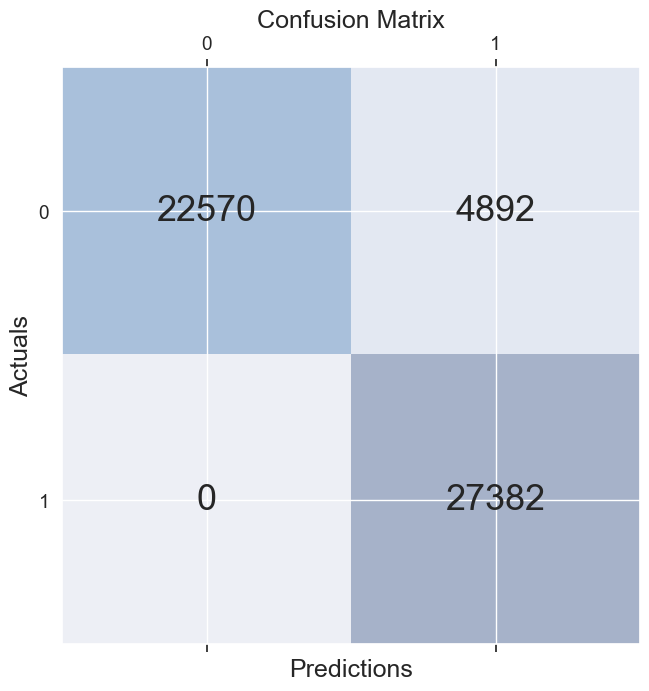

In [16]:
#Evaluamos el modelo
y_validacion_pred = xgb_model.predict(X_prueba)
conf_matrix = confusion_matrix(y_true=y_prueba, y_pred=y_validacion_pred)
# Imprimimos la matriz de confusión
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

<h3>Resultado del Modelo</h3>

In [17]:
print("\nPrecisión: {:.4f}".format(accuracy_score(y_prueba, y_validacion_pred)))
print("\nRecall: {:.4f}".format(recall_score(y_prueba, y_validacion_pred,zero_division=1)))
print("\nF1: {:.4f}".format(f1_score(y_prueba, y_validacion_pred,zero_division=1)))


Precisión: 0.9108

Recall: 1.0000

F1: 0.9180


<h4>Conclusión</h4>
<p>Podemos Ver como ahora si clasifica correctamente los casos positivos y negativos</p>
<p>La Matriz de Confusión nos indica que los verdaderos negativos y verdaderos positivos son los mas numerosos</p>
<p>La precisión es mayor al 90% lo que nos indica que es excepcionalmente buen clasificador</p>